# Deep Learning for NLP - Project

### Student : Yonatan DELORO

### Contact : yonatan.deloro@eleves.enpc.fr

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, Flatten, Reshape
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

/home/yonatan/.local/lib/python2.7/site-packages/h5py-2.7.1-py2.7-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        #self.word2id = dict.fromkeys(self.word2vec.keys())
        self.word2id = {word: idx for (idx, word) in enumerate(list(self.word2vec.keys()))}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
        
   
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ',1)
                #punctuations might be useful for sentiment analysis
                self.word2vec[word] = np.fromstring(vec, sep=' ')                
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
                        
        idx_w = self.word2id[w]
        embedding_w = self.embeddings[idx_w]
        
        knn = self.most_similar_to_embedding(embedding_w, K=K+1)
        #we ask for the K+1 most similar words
        #as the word w belong itself to word2vec and will be the first output in knn
        
        return knn[1:]

    def most_similar_to_embedding(self,embedding, K=5):
        # K most similar words to the given embedding
        # intermediary function built for part II (multilingual embedding)
        
        N_words = len(self.id2word)
        
        scores = np.zeros(N_words)
        for idx in self.id2word.keys():
            scores[idx] = self.similarity(embedding,self.embeddings[idx])
        
        idx_sorted = np.argsort(-scores) #index of words sorted by decreasing similarity
        idx_knn = idx_sorted[:K].flatten() #idx of K most similar words
                
        words = []
        for i in range(idx_knn.shape[0]):
            word = self.id2word[idx_knn[i]]
            words.append(word)
            
        return words
        
    def similarity(self, embedding1, embedding2):
        
        norm1 = np.linalg.norm(embedding1)
        norm2 = np.linalg.norm(embedding2)
        
        return np.dot(embedding1,embedding2)/(norm1*norm2)

    def score(self, w1, w2):
        
        # cosine similarity: np.dot  -  np.linalg.norm
        embedding_w1 = self.embeddings[self.word2id[w1]]
        embedding_w2 = self.embeddings[self.word2id[w2]]
        
        return self.similarity(embedding_w1, embedding_w2)


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
print("similarity scores : ")
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))

print("##########")
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print("\n"+w1)
    print("most similar words :")
    for w in w2v.most_similar(w1):
        print(w)

Loaded 200000 pretrained word vectors
similarity scores : 
('cat', 'dog', 0.671683666279249)
('dog', 'pet', 0.6842064029669219)
('dogs', 'cats', 0.7074389328052405)
('paris', 'france', 0.7775108541288561)
('germany', 'berlin', 0.7420295235998394)
##########

cat
most similar words :
cats
kitty
kitten
feline
kitties

dog
most similar words :
dogs
puppy
Dog
doggie
canine

dogs
most similar words :
dog
pooches
Dogs
doggies
canines

paris
most similar words :
france
Paris
parisian
london
berlin

germany
most similar words :
austria
europe
german
berlin
poland


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []

        for sent in sentences:
                        
            embedding = np.zeros(300)
            num_words = 0
            words = sent.split(' ')
                        
            if idf is False:
                # mean of word vectors
                for word in words:
                    try: #to cover the case where word is not in self.w2v.word2id.keys():
                        embedding += self.w2v.embeddings[self.w2v.word2id[word]]        
                        num_words += 1
                    except:
                        pass
            else:
                # idf-weighted mean of word vectors
                for word in words:
                    try: #to cover the case where word is not in self.w2v.word2id.keys():
                        id_word = self.w2v.word2id[word]
                        embedding += self.w2v.embeddings[id_word]*idf[id_word]
                        num_words += 1
                    except:
                        pass
            
            if num_words>0:
                embedding /= num_words
            sentemb.append(embedding)
                
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf=idf)
        query = self.encode([s], idf=idf)
        
        scores = []
        for i in range(keys.shape[0]):
            scores.append(self.similarity(query.flatten(), keys[i].flatten()))
            
        scores = np.array(scores)        
        idx_sorted = np.argsort(-scores) #index of sentences sorted by decreasing similarity
        idx_knn = idx_sorted[:K+1].flatten() #idx of K+1 most similar sentences
                                             #(includes the sentence itself)
        print("\nconsidered sentence : \n")
        print(s)
        print("most similar sentences : ")
        
        res = []
        for i in idx_knn[1:]:
            sent = sentences[i]
            print("\n"+sent)
            res.append(sent)
            
        return res
    
    def similarity(self, embedding1, embedding2):
        return np.dot(embedding1,embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        embedding1 = self.encode([s1],idf=idf).flatten()
        embedding2 = self.encode([s2],idf=idf).flatten()
        return self.similarity(embedding1, embedding2)
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}

        num_sentences = 0
        for sent in sentences:
            num_sentences +=1
            words = sent.split(' ')
            for word in set(words): #set(words) to count only 1 if the word appears multiple times in the document
                try: #to cover the case where word is not in self.w2v.word2id.keys():
                    idx = self.w2v.word2id[word]
                    if idx in idf.keys():
                        idf[idx] += 1
                    else:
                        idf[idx] = 1
                except:
                    pass

        for (idx,value) in idf.items():
            idf[idx] = np.log(num_sentences / value)
            
        return idf
    
def load_sentences(fname):
    sentences = []
    with io.open(PATH_TO_DATA+fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            sentences.append(line)
    return sentences

In [6]:
#w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = load_sentences("sentences.txt")
        
idf  = s2v.build_idf(sentences)

##################################################
##################################################

print("##############")

print("BoV-mean")
# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean

print("##############")

sent1 = sentences[7]
sent2 = sentences[13]
print("sentence 1 : "+sent1)
print("sentence 2 : "+sent2)
print("similarity score : ",s2v.score('' if not sentences else sent1, '' if not sentences else sent2))

print("\n##############")
print("##############\n")
print("BoV-idf")

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf

print("##############")

print("sentence 1 : "+sent1)
print("sentence 2 : "+sent2)
print("similarity score : ",s2v.score('' if not sentences else sent1, '' if not sentences else sent2, idf))

##############
BoV-mean

considered sentence : 

1 woman in a black jacket is drinking out of a bottle while others are smiling . 

most similar sentences : 

a man in a pink shirt and a woman in a teal shirt , who is drinking wine , are sitting in a dark corner and talking . 


a woman in a blue shirt is laughing with a woman in a black shirt outside , as people are sitting and standing all around them . 


a man in a black jacket with a white stripe on the sleeve is holding a drink and laughing while a woman watches . 


a man in a white shirt squirting a bottle of a drink and smiling . 


the women in a red jacket is drinking from her cup , while the man in green cap is staring to his left . 

##############
sentence 1 : 1 man standing and several people sitting down waiting on a subway train . 

sentence 2 : 10 women dressed in long black dresses holding a booklet up sheet music in front of them singing in a choir. you can see the back of 3 older gentlemen heads who appear to be th

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

#in terminal line from the data folder, I first wrote to download the data :
#wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vecz

N = 50000
        
w2v = {}
w2v["fr"] = Word2vec(PATH_TO_DATA+"wiki.fr.vec", N) 
w2v["en"] = Word2vec(PATH_TO_DATA+"wiki.en.vec", N) 

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

anchors = set(w2v["fr"].word2id.keys()).intersection(set(w2v["en"].word2id.keys()))
anchors = list(anchors) #anchor words

anchors_id = {"fr": [], "en": []}
for word in anchors:
    anchors_id["fr"].append(w2v["fr"].word2id[word])  #id of achor_word in french w2v
    anchors_id["en"].append(w2v["en"].word2id[word])  #id of achor_word in english w2v
    
X = w2v["fr"].embeddings[anchors_id["fr"]]
Y = w2v["en"].embeddings[anchors_id["en"]]

print(X.shape, Y.shape)

((18970, 300), (18970, 300))


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

YTX = Y.T.dot(X)    
U, s, VT = scipy.linalg.svd(YTX, full_matrices=True)
W  = U.dot(VT)

#English to French mapping
Winv = np.linalg.inv(W)

print(W.shape)

(300, 300)


In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def foreign_neighbors(word, foreign="fr", K=5):

    if foreign=="fr":
        embedding_word_en = w2v["en"].embeddings[w2v["en"].word2id[word]]
        embedding_word_fr = Winv.dot(embedding_word_en)
        return w2v["fr"].most_similar_to_embedding(embedding_word_fr)
    
    elif foreign=="en":
        embedding_word_fr = w2v["fr"].embeddings[w2v["fr"].word2id[word]]
        embedding_word_en = W.dot(embedding_word_fr)
        return w2v["en"].most_similar_to_embedding(embedding_word_en)
    
    else:
        print("'foreign' should be 'fr' or 'en'")
    
    
print("English to French")
words_en = np.random.choice(w2v["en"].word2id.keys(),5)
for word in words_en:
    print("\nword : "+word)
    print("French nearest neighbors : ")
    for w in foreign_neighbors(word, foreign="fr", K=5):
        print(w)
    #print([w.format() )
    
print("\n##########################\n")

print("French to English")
words_fr = np.random.choice(w2v["fr"].word2id.keys(),5)
for word in words_fr:
    print("\nword : "+word)
    print("English nearest neighbors : ")
    for w in foreign_neighbors(word, foreign="en", K=5):
        print(w)

English to French

word : ovate
French nearest neighbors : 
lancéolées
pétiole
bractées
sépales
folioles

word : agonists
French nearest neighbors : 
sérotonine
inhibiteurs
récepteurs
inhibiteur
inflammatoires

word : église
French nearest neighbors : 
église
eglise
paroissiale
chapelle
abbatiale

word : stalker
French nearest neighbors : 
scream
psychopathe
killer
punisher
sadique

word : cheddar
French nearest neighbors : 
cheese
fromage
worcestershire
jambon
oignons

##########################

French to English

word : décision
English nearest neighbors : 
decision
decisions
overrule
sanction
deliberations

word : agglo
English nearest neighbors : 
agglomeration
essonne
morbihan
charentes
sarthe

word : dietrich
English nearest neighbors : 
dietrich
eberhard
helmuth
bernhard
wilhelm

word : delattre
English nearest neighbors : 
marchand
gauthier
françois
lacroix
clément

word : salat
English nearest neighbors : 
prat
salah
garonne
allah
ariège


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_sentences_with_labels(fname):
    sentences = []
    labels = []
    with io.open(PATH_TO_DATA+fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            labels.append(int(line[0]))
            sentences.append(line[2:])
    return sentences, labels

sentences = {}
labels = {}
sets = ["train","dev","test.X"]

sentences["train"], labels["train"] = load_sentences_with_labels("SST/stsa.fine.train")
sentences["dev"], labels["dev"] = load_sentences_with_labels("SST/stsa.fine.dev")
sentences["test.X"] = load_sentences("SST/stsa.fine.test.X")

In [12]:
# 2 - Encode sentences with the BoV model above

#w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

all_sentences = sentences["train"] + sentences["dev"] + sentences["test.X"]
idf  = s2v.build_idf(all_sentences)

embeddings = {}
for s in sets:
    #embeddings[s] = s2v.encode(sentences[s])
    embeddings[s] = s2v.encode(sentences[s], idf = idf)

Loaded 200000 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


#looking for best best alpha (l2 regularization intensity)
#set_alpha = [10**(p-5) for p in range(10)] #first, coarse
set_alpha = np.linspace(50,150,21) #then, finer
losses_dev = []

for alpha in set_alpha:
    
    # from scikit documentation : uses the cross- entropy loss if the ‘multi_class’ option is set to ‘multinomial’
    LR = LogisticRegression(multi_class="multinomial",solver="lbfgs",
                            penalty='l2', C=1./alpha)
        
    LR.fit(embeddings["train"],labels["train"])
    #print(LR.score(embeddings["dev"],labels["dev"]))
    predictions_probas = LR.predict_proba(embeddings["dev"])
    losses_dev.append(log_loss(labels["dev"],predictions_probas))

    
    
#plotting loss on dev against alpha
#plt.semilogx(set_alpha,losses_dev)
plt.plot(set_alpha,losses_dev)
plt.xlabel("alpha (regularization cste)")
plt.ylabel("cross-entropy loss on dev set")
plt.show()

idx_best_alpha = np.argmin(losses_dev) 
chosen_alpha = set_alpha[idx_best_alpha]
print("chosen alpha : ", chosen_alpha)



#training LR with best alpha found
LR = LogisticRegression(multi_class="multinomial",solver="lbfgs",
                        penalty='l2', C=1./chosen_alpha)    
LR.fit(embeddings["train"],labels["train"],)

predictions = LR.predict(embeddings["dev"])
print("score on train : ", LR.score(embeddings["train"],labels["train"]))
print("score on dev : ", LR.score(embeddings["dev"],labels["dev"]))

predictions_probas = LR.predict_proba(embeddings["train"])
print("loss on train : ", log_loss(labels["train"],predictions_probas))

predictions_probas = LR.predict_proba(embeddings["dev"])
print("loss on dev : ", log_loss(labels["dev"],predictions_probas))

<Figure size 640x480 with 1 Axes>

('chosen alpha : ', 90.0)
('score on train : ', 0.47992508486480157)
('score on dev : ', 0.42727272727272725)
('loss on train : ', 1.221294735034186)
('loss on dev : ', 1.3178251269927477)


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

#Predicting the labels the Test Set
predictions = LR.predict(embeddings["test.X"])

print("Plotting some predictions on the Test Set")
print("#########################")

for label in range(5):
    print("some sentences with predicted label "+str(label)+"\n")
    selection = np.random.choice(np.argwhere(predictions==label).flatten(),3)
    for i in selection:
        print(sentences["test.X"][i])
    print("#########################")
    
np.savetxt('logreg_bov_y_test_sst.txt', predictions, fmt='%i', delimiter='\t')

Plotting some predictions on the Test Set
#########################
some sentences with predicted label 0

made by jackasses for jackasses .

flaccid drama and exasperatingly slow journey .

godawful boring slug of a movie .

#########################
some sentences with predicted label 1

this one 's weaker than most .

maybe it 's the star power of the cast or the redundant messages , but something aboul `` full frontal '' seems , well , contrived .

just because it really happened to you , honey , does n't mean that it 's interesting to anyone else .

#########################
some sentences with predicted label 2

god help the poor woman if attal is this insecure in real life : his fictional yvan 's neuroses are aggravating enough to exhaust the patience of even the most understanding spouse .

the writers , director wally wolodarsky , and all the actors should start their own coeducational fraternity : kappa rho alpha phi .

earns its laughs from stock redneck ` types ' and from t

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

#Trying Multi-Class SVM with Gaussian Kernel
#Small grid search for C penalty for misclassified data
#Automatical choice for the variance parameter of the Gaussian Kernel


from sklearn.svm import SVC

if False:
    #to find best C (take much time)
    set_C = np.linspace(1,10,10) #search
    scores_dev = []

    for C in set_C:

        SVM = SVC(C=C,kernel='rbf',gamma='auto')        
        SVM.fit(embeddings["train"],labels["train"])
        scores_dev.append(SVM.score(embeddings["dev"],labels["dev"]))

    plt.plot(set_C,scores_dev)
    plt.xlabel("C (penalty for outlier / misclassified data)")
    plt.ylabel("classification score on dev set")
    plt.show()
    
    idx_best_C = np.argmax(scores_dev) 
    chosen_C = set_C[idx_best_C]
else:
    #best C was found equal to 6 with the grid search above
    chosen_C = 6.0

    
#Fitting SVM with best C
print("chosen C : ", chosen_C)

SVM = SVC(C=chosen_C,kernel='rbf',gamma='auto')
SVM.fit(embeddings["train"],labels["train"])
print("score on train : ", SVM.score(embeddings["train"],labels["train"]))
print("score on dev : ", SVM.score(embeddings["dev"],labels["dev"]))


#Predicting the labels the Test Set
predictions = SVM.predict(embeddings["test.X"])

print("Plotting some predictions on the Test Set")
print("#########################")

for label in range(5):
    print("some sentences with predicted label "+str(label)+"\n")
    selection = np.random.choice(np.argwhere(predictions==label).flatten(),3)
    for i in selection:
        print(sentences["test.X"][i])
    print("#########################")
    
np.savetxt('svm_bov_y_test_sst.txt', predictions, fmt='%i', delimiter='\t')

('chosen C : ', 6.0)
('score on train : ', 0.5644387217605057)
('score on dev : ', 0.43454545454545457)
Plotting some predictions on the Test Set
#########################
some sentences with predicted label 0

flaccid drama and exasperatingly slow journey .

a trashy , exploitative , thoroughly unpleasant experience .

unfortunately , the picture failed to capture me .

#########################
some sentences with predicted label 1

writer\/director john mckay ignites some charming chemistry between kate and jed but , when he veers into sodden melodrama , punctuated by violins , it 's disastrous and kate 's jealous female friends become downright despicable .

it represents better-than-average movie-making that does n't demand a dumb , distracted audience .

splashes its drama all over the screen , subjecting its audience and characters to action that feels not only manufactured , but also so false you can see the filmmakers ' puppet strings .

#########################
some sentence

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras

In [17]:
# 1 - Load train/dev/test sets of SST

entire_text = ""
for s in sets:
    for sent in sentences[s]:
        entire_text = entire_text + " " + sent

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot

size_vocab = len(np.unique(text_to_word_sequence(entire_text)))
print("size of vocabulary provided to one_hot : ", size_vocab)

encoded_text = one_hot(entire_text, size_vocab)

processed_sentences = {}
cpt = 0
for s in sets:
    processed_sentences[s] = []
    for sent in sentences[s]:
        l = len(text_to_word_sequence(sent))
        processed_sentences[s].append(encoded_text[cpt:cpt+l])
        cpt+=l
        
assert(cpt==len(encoded_text))

('size of vocabulary provided to one_hot : ', 17837)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

for s in sets:
    processed_sentences[s] = pad_sequences(processed_sentences[s])
    
from keras.utils import to_categorical
    
x_train = processed_sentences["train"]
y_train = to_categorical(np.array(labels["train"]),5)

x_val = processed_sentences["dev"]
y_val = to_categorical(np.array(labels["dev"]),5)

x_test = processed_sentences["test.X"]

print(x_train.shape, y_train.shape)    
print(x_val.shape, y_val.shape)    
print(x_test.shape)

((8543, 49), (8543, 5))
((1100, 44), (1100, 5))
(2209, 52)


## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64 #64  # number of hidden units in the LSTM
vocab_size = size_vocab  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
#model.add(Dropout(0.2))
model.add(LSTM(nhid, dropout_W=0.4, dropout_U=0.4))
model.add(Dense(n_classes, activation='sigmoid'))

/home/yonatan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.4, recurrent_dropout=0.4)`


In [21]:
# 5 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          570784    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 595,941
Trainable params: 595,941
Non-trainable params: 0
_________________________________________________________________
None


/home/yonatan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 8543 samples, validate on 1100 samples
Epoch 1/6
8543/8543 [==============================] - 8s 886us/step - loss: 1.5766 - acc: 0.2647 - val_loss: 1.5696 - val_acc: 0.2545
Epoch 2/6
8543/8543 [==============================] - 7s 824us/step - loss: 1.5424 - acc: 0.3055 - val_loss: 1.4915 - val_acc: 0.3464
Epoch 3/6
8543/8543 [==============================] - 7s 795us/step - loss: 1.3671 - acc: 0.3893 - val_loss: 1.4202 - val_acc: 0.3773
Epoch 4/6
8543/8543 [==============================] - 7s 770us/step - loss: 1.1778 - acc: 0.4596 - val_loss: 1.4414 - val_acc: 0.3609


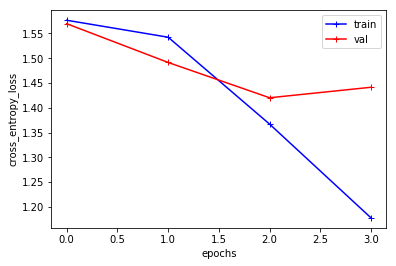

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 64
n_epochs = 6

early_stopping_monitor = EarlyStopping(patience = 0)
        
history = model.fit(x_train, y_train, 
                    batch_size=bs, nb_epoch=n_epochs, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping_monitor])

losses = {}
losses["train"] = history.history['loss']
losses["val"] = history.history['val_loss']
epochs = np.arange(len(losses['train']))
plt.plot(epochs,losses['train'],marker="+",color="b",label="train")
plt.plot(epochs,losses['val'],marker="+",color="r",label="val")
plt.xlabel("epochs") ; plt.ylabel("cross_entropy_loss") ; plt.legend()
plt.savefig('q4_plot.png')
plt.show()

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

#Predicting the labels the Test Set
predictions = np.argmax(model.predict(x_test),axis=1)

print("Plotting some predictions on the Test Set")
print("#########################")

for label in range(5):
    print("some sentences with predicted label "+str(label)+"\n")
    subset = np.argwhere(predictions==label)
    if len(subset)>0:
        selection = np.random.choice(subset.flatten(),3)
        for i in selection:
            print(sentences["test.X"][i])
    print("#########################")
    
np.savetxt('logreg_lstm_y_test_sst.txt', predictions, fmt='%i', delimiter='\t')

Plotting some predictions on the Test Set
#########################
some sentences with predicted label 0

so i just did .

the performances are so leaden , michael rymer 's direction is so bloodless and the dialogue is so corny that the audience laughs out loud .

can see where this dumbed-down concoction is going .

#########################
some sentences with predicted label 1

the premise is in extremely bad taste , and the film 's supposed insights are so poorly thought-out and substance-free that even a high school senior taking his or her first psychology class could dismiss them .

between the drama of cube ?

it settles for being merely grim .

#########################
some sentences with predicted label 2

this pep-talk for faith , hope and charity does little to offend , but if saccharine earnestness were a crime , the film 's producers would be in the clink for life .

the enormous comic potential of an oafish idiot impersonating an aristocrat remains sadly unrealized .



## 4.3 -- innovate !

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

#One could maybe try a Multi-Class SVM on the outputs of the LSTM Layer
#However, I did not find time to investigate more on the topic
#with the several projects for January....
#But this TP was very interesting, thanks !